In [1]:
player_name_input = input("Enter a player name (Last, First): ").strip()

Enter a player name (Last, First):  Niu, Maika


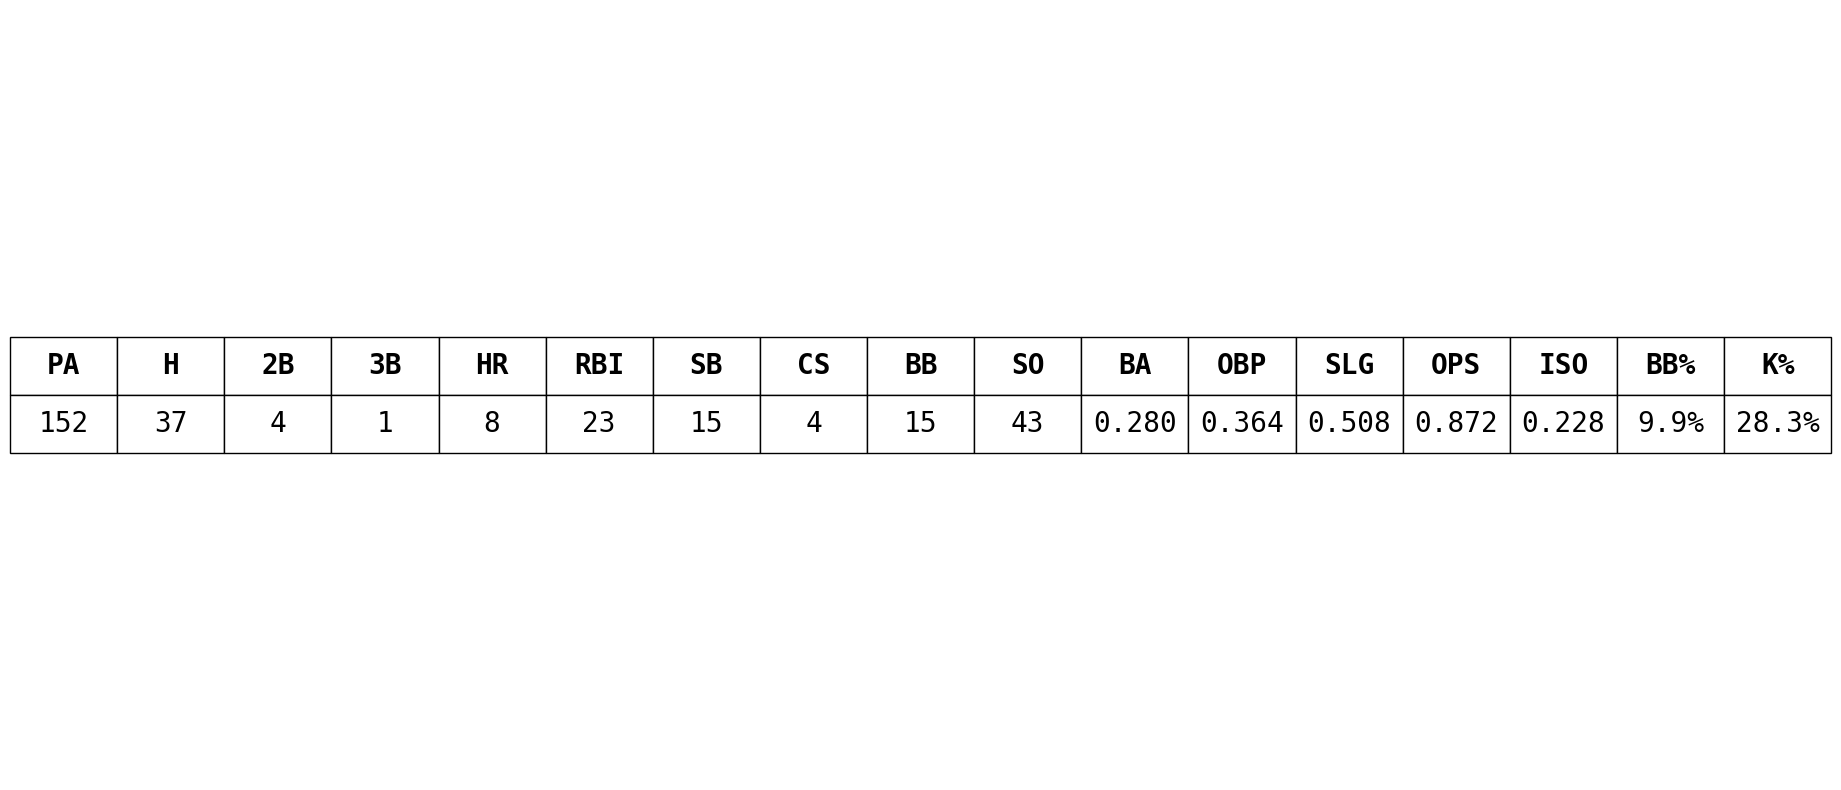

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from io import StringIO
import httpx
import matplotlib as mpl
from bs4 import BeautifulSoup, Comment
import seaborn as sns
import numpy as np
import matplotlib.patches as patches

mpl.rcParams['font.family'] = 'DejaVu Sans Mono'

def basic_stats_table(ax: plt.Axes):

    warnings.filterwarnings("ignore", category=FutureWarning)

    #CHANGE
    url = "https://www.baseball-reference.com/register/player.fcgi?id=niu---000mai"

    headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
    }

    response = httpx.get(url, headers=headers)

    soup = BeautifulSoup(response.text, 'html.parser')

    table = soup.find('table', id='standard_batting')

    df = pd.read_html(str(table), flavor='lxml')[0]
    
    df.columns = df.columns.str.strip()
    df["Tm"] = df["Tm"].str.strip()

    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

    df = df.dropna(subset=['Year'])

    df["Tm"] = df["Tm"].str.replace("\u00A0", " ").str.strip()

    filtered_df = df[
        (df["Year"].isin([2025])) & (df["Tm"] == "Falmouth") #CHANGE BOTH
    ].copy() 

    filtered_df["ISO"] = pd.to_numeric(filtered_df["SLG"], errors="coerce") - pd.to_numeric(filtered_df["BA"], errors="coerce")

    filtered_df["BB%"] = (filtered_df["BB"] / filtered_df["PA"]) * 100
    filtered_df["K%"] = (filtered_df["SO"] / filtered_df["PA"]) * 100

    filtered_df["BB%"] = filtered_df["BB%"].map("{:.1f}%".format)
    filtered_df["K%"] = filtered_df["K%"].map("{:.1f}%".format)

    filtered_df["OPS"] = (filtered_df["OBP"] + filtered_df["SLG"])

    filtered_df["OPS"] = filtered_df["OPS"].map("{:.3f}".format)
    
    final_df = filtered_df[["PA", "H", "2B", "3B", "HR", "RBI", "SB", "CS", "BB", "SO", "BA", "OBP", "SLG", "OPS", "ISO", "BB%", "K%"]]

    final_df = final_df.copy()

    int_cols = ["PA", "H", "3B", "HR", "RBI", "SB", "CS", "BB", "SO"]
    for col in int_cols:
        final_df.loc[:, col] = final_df[col].astype(int)

    final_df.loc[:, "BA"] = final_df["BA"].astype(float).map("{:.3f}".format)
    final_df.loc[:, "OBP"] = final_df["OBP"].astype(float).map("{:.3f}".format)
    final_df.loc[:, "SLG"] = final_df["SLG"].astype(float).map("{:.3f}".format)
    final_df.loc[:, "ISO"] = final_df["ISO"].astype(float).map("{:.3f}".format)
    
    basic_stats_table = ax.table(
        cellText=final_df.values, 
        colLabels=final_df.columns, 
        loc="center", 
        cellLoc="center", 
        colLoc="center"
    )

    for (i, j), cell in basic_stats_table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold')

    basic_stats_table.auto_set_font_size(False)
    basic_stats_table.set_fontsize(20)
    basic_stats_table.scale(2.35, 3.5)

    ax.axis("off")

basic_stats_table(ax=plt.subplots(figsize=(10, 10))[1])
plt.show()

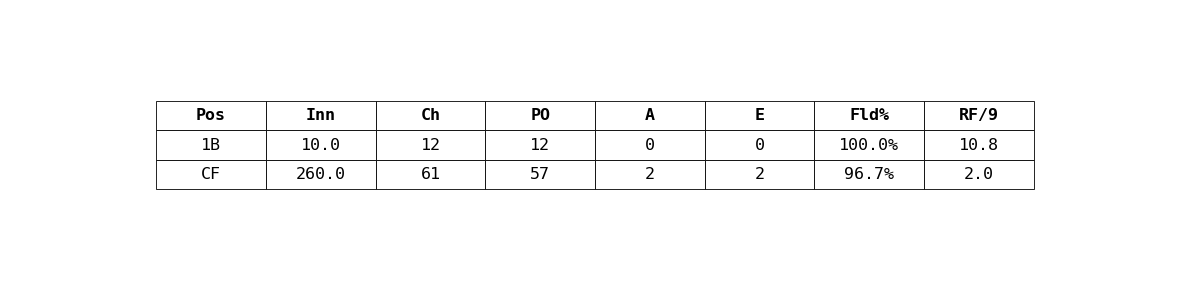

In [17]:
def get_filtered_falmouth_fielding(url: str) -> pd.DataFrame:
    warnings.filterwarnings("ignore", category=FutureWarning)

    headers = {
        "User-Agent": "Mozilla/5.0"
    }

    response = httpx.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    comments = soup.find_all(string=lambda text: isinstance(text, Comment))

    fielding_table_html = None
    for comment in comments:
        if 'id="standard_fielding"' in comment:
            fielding_table_html = BeautifulSoup(comment, "html.parser").find("table", id="standard_fielding")
            break

    if fielding_table_html is None:
        raise ValueError("No fielding table found in the HTML comments.")

    df = pd.read_html(str(fielding_table_html))[0]

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel()

    df.columns = df.columns.str.strip()

    if "Unnamed: 6" in df.columns:
        df = df.rename(columns={"Unnamed: 6": "Pos"})

    df = df[df["Tm"].str.strip() == "Falmouth"]
    df = df[df["Pos"].str.strip() != "OF"]

    desired_columns = ["Pos", "Inn", "Ch", "PO", "A", "E", "Fld%", "RF/9"]
    available_columns = [col for col in desired_columns if col in df.columns]

    return df[available_columns].reset_index(drop=True)

url = "https://www.baseball-reference.com/register/player.fcgi?id=niu---000mai"
filtered_stats = get_filtered_falmouth_fielding(url)

def format_fielding_table(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    for col in ["Ch", "PO", "A", "E"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").map(lambda x: f"{int(x)}" if pd.notnull(x) else "")
    
    if "RF/9" in df.columns:
        df["RF/9"] = pd.to_numeric(df["RF/9"], errors="coerce").map(lambda x: f"{x:.1f}" if pd.notnull(x) else "")
    
    if "Fld%" in df.columns:
        df["Fld%"] = pd.to_numeric(df["Fld%"], errors="coerce").map(lambda x: f"{x * 100:.1f}%" if pd.notnull(x) else "")
    
    return df

formatted_stats = format_fielding_table(filtered_stats)

def display_fielding_table(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(12, 2 + 0.5 * len(df)))

    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(.75, 1.5)

    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold')

    for key, cell in table.get_celld().items():
        cell.set_linewidth(0.6)

    plt.tight_layout()
    plt.show()

display_fielding_table(formatted_stats)

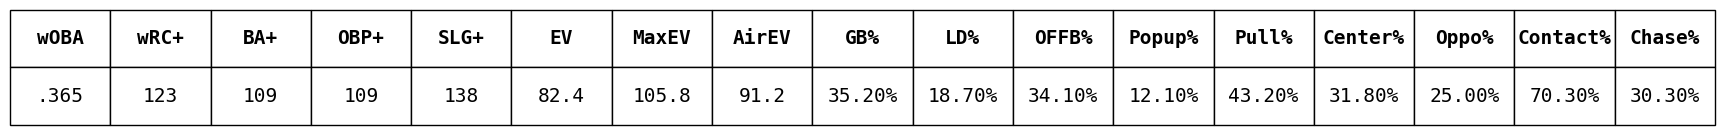

In [21]:
tm_df = pd.read_excel(r"C:\Users\brend\OneDrive - Stonehill College\All Cape League Trackman.xlsx")

def combined_stats_table(ax: plt.Axes, player_filter: str):
    warnings.filterwarnings("ignore", category=FutureWarning)

    adv_data = {
        "wOBA": [".365"],
        "wRC+": ["123"],
        "BA+": ["109"],
        "OBP+": ["109"],
        "SLG+": ["138"],
    }
    adv_df = pd.DataFrame(adv_data)

    standardized_name = player_filter.lower().replace(" ", "").replace(",", "")

    df = pd.read_csv(r"C:\Users\brend\Downloads\Falmouth - Scout.csv")
    df["playerFullName"] = df["playerFullName"].apply(
        lambda x: f"{x.split()[-1]}, {' '.join(x.split()[:-1])}".strip()
    )
    df["normalizedName"] = (
        df["playerFullName"]
        .str.lower()
        .replace(",", "", regex=True)
        .str.replace(" ", "", regex=False)
    )
    df = df[df["normalizedName"] == standardized_name]

    target_cols = ["Ground%", "Line%", "Fly%", "Popup%", 
                   "HPull%", "HCtr%", "HOppFld%", "Contact%", "Chase%"]
    display_df = df[target_cols].copy() if not df.empty else pd.DataFrame(columns=target_cols)

    display_df.rename(columns={
        "Ground%": "GB%",
        "Line%": "LD%",
        "Fly%": "OFFB%",
        "Popup": "P%",
        "HPull%": "Pull%",
        "HCtr%": "Center%",
        "HOppFld%": "Oppo%"
    }, inplace=True)

    if not display_df.empty:
        for col in display_df.columns:
            display_df[col] = (
                display_df[col]
                .astype(str)
                .str.replace("%", "", regex=False)
                .str.strip()
                .astype(float)
                .map("{:.2f}".format)
                .astype(str) + "%"
            )
    else:
        display_df.loc[0] = [""] * len(target_cols)

    player_df = tm_df[tm_df["Batter"] == player_filter]
    player_df = player_df[player_df["PitchCall"] == "InPlay"]

    if not player_df.empty and "ExitSpeed" in player_df.columns:
        ev = player_df["ExitSpeed"].mean()
        max_ev = player_df["ExitSpeed"].max()

        air_ev_df = player_df[player_df["TaggedHitType"].isin(["LineDrive", "FlyBall"])]
        if not air_ev_df.empty:
            air_ev = air_ev_df["ExitSpeed"].mean()
            adv_df["AirEV"] = f"{air_ev:.1f}"
        else:
            adv_df["AirEV"] = ""

        adv_df["EV"] = f"{ev:.1f}"
        adv_df["MaxEV"] = f"{max_ev:.1f}"
    else:
        adv_df["EV"] = ""
        adv_df["MaxEV"] = ""
        adv_df["AirEV"] = ""

    adv_df = adv_df.reset_index(drop=True).iloc[[0]]
    display_df = display_df.reset_index(drop=True).iloc[[0]]

    cols = list(adv_df.columns)
    maxev_idx = cols.index("MaxEV") + 1
    cols.insert(maxev_idx, cols.pop(cols.index("AirEV")))
    adv_df = adv_df[cols]

    combined_df = pd.concat([adv_df, display_df], axis=1)

    table = ax.table(
        cellText=combined_df.values,
        colLabels=combined_df.columns,
        loc="center",
        cellLoc="center",
        colLoc="center",
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(.6, 1)

    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold')

    ax.axis("off")

fig, ax = plt.subplots(figsize=(22, 1.5))
combined_stats_table(ax=ax, player_filter=player_name_input)
plt.show()

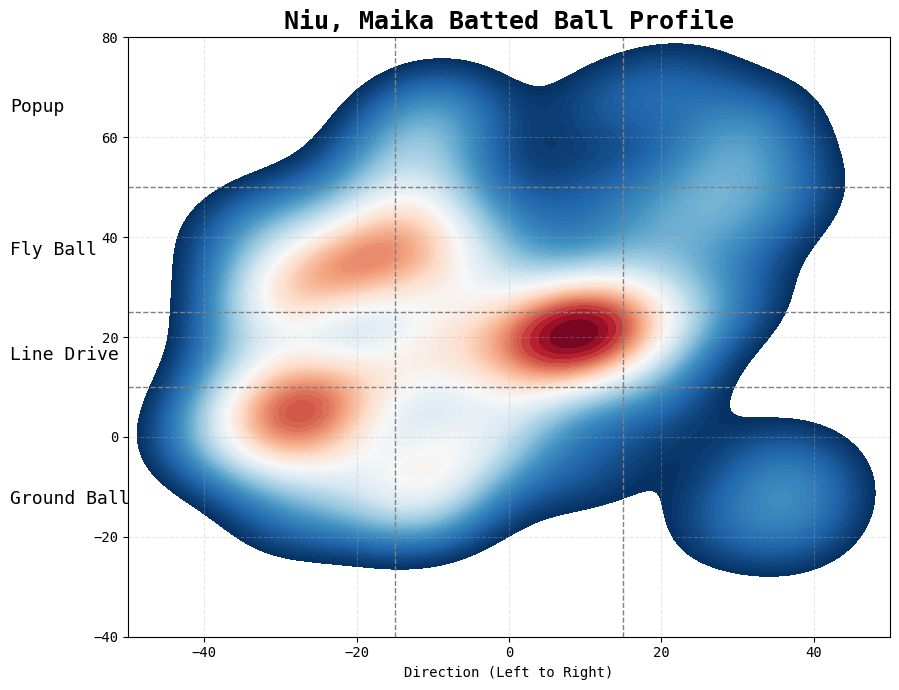

In [27]:
filtered_df = tm_df[
    (tm_df['BatterTeam'] == 'FAL_COM') &
    (tm_df['PitchCall'] != 'FoulBallNotFieldable') &
    (tm_df['Angle'].between(-20, 80)) &
    (tm_df['Direction'].between(-60, 60))
].dropna(subset=['Angle', 'Direction', 'Batter'])

batter_df = filtered_df[filtered_df['Batter'] == player_name_input]

if len(batter_df) < 2:
    print(f"Not enough data to plot for {player_name_input}")
else:
    plt.figure(figsize=(9, 7))
    sns.kdeplot(
        data=batter_df, 
        x="Direction", 
        y="Angle", 
        fill=True, 
        cmap="RdBu_r", 
        bw_adjust=0.7, 
        thresh=0.05, 
        levels=100
    )

    plt.axhline(10, color='gray', linestyle='--', linewidth=1)
    plt.axhline(25, color='gray', linestyle='--', linewidth=1)
    plt.axhline(50, color='gray', linestyle='--', linewidth=1)

    plt.axvline(-15, color='gray', linestyle='--', linewidth=1)
    plt.axvline(15, color='gray', linestyle='--', linewidth=1)

    plt.text(-65.5, 66, "Popup", va='center', ha='left', fontsize=13, color='black')
    plt.text(-65.5, 37.5, "Fly Ball", va='center', ha='left', fontsize=13, color='black')
    plt.text(-65.5, 16.5, "Line Drive", va='center', ha='left', fontsize=13, color='black')
    plt.text(-65.5, -12.5, "Ground Ball", va='center', ha='left', fontsize=13, color='black')

    plt.xlim(-50, 50)
    plt.ylim(-40, 80)

    plt.title(f"{player_name_input} Batted Ball Profile", fontsize=18, fontweight='bold')
    plt.xlabel("Direction (Left to Right)")
    plt.ylabel("")
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

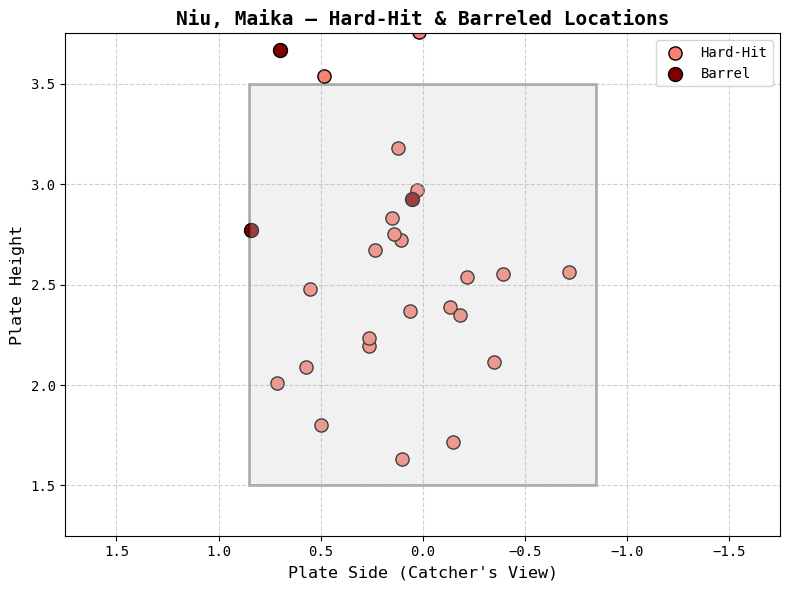

In [29]:
for col in ['ExitSpeed', 'Angle', 'PlateLocHeight', 'PlateLocSide']:
    tm_df[col] = pd.to_numeric(tm_df[col], errors='coerce')

player_df = tm_df[
    (tm_df['BatterTeam'] == 'FAL_COM') &
    (tm_df['Batter'] == player_name_input)
]

hard_hit_df = player_df[player_df['ExitSpeed'] >= 93.5].dropna(subset=['PlateLocHeight', 'PlateLocSide'])

barreled_df = player_df[player_df['ExitSpeed'] >= 96].copy()
barreled_df['lower_angle'] = 26 - (barreled_df['ExitSpeed'] - 96)
barreled_df['upper_angle'] = 30 + (barreled_df['ExitSpeed'] - 96)

barreled_df = barreled_df[
    (barreled_df['Angle'] >= barreled_df['lower_angle']) &
    (barreled_df['Angle'] <= barreled_df['upper_angle'])
].dropna(subset=['PlateLocHeight', 'PlateLocSide'])

if len(hard_hit_df) > 0:
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(
        hard_hit_df['PlateLocSide'],
        hard_hit_df['PlateLocHeight'],
        color='salmon',
        edgecolor='black',
        s=90,
        label='Hard-Hit'
    )

    if len(barreled_df) > 0:
        ax.scatter(
            barreled_df['PlateLocSide'],
            barreled_df['PlateLocHeight'],
            color='#800000',
            edgecolor='black',
            s=100,
            label='Barrel'
        )

    zone_bottom = 1.5
    zone_top = 3.5
    zone_half_width = 0.85
    strike_zone = patches.Rectangle(
        (-zone_half_width, zone_bottom),
        zone_half_width * 2,
        zone_top - zone_bottom,
        linewidth=2,
        edgecolor='black',
        facecolor='lightgrey',
        alpha=0.3
    )
    ax.add_patch(strike_zone)

    ax.set_xlim(1.75, -1.75)
    ax.set_ylim(1.25, 3.75)
    ax.set_title(f'{player_name_input} — Hard-Hit & Barreled Locations', fontsize=14, fontweight='bold')
    ax.set_xlabel("Plate Side (Catcher's View)", fontsize=12)
    ax.set_ylabel('Plate Height', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
else:
    print(f"No hard-hit balls found for {player_name_input}.")

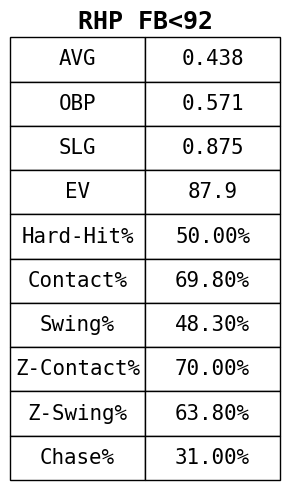

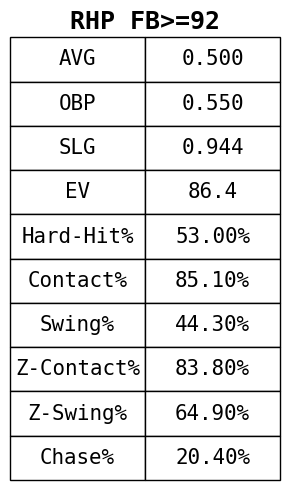

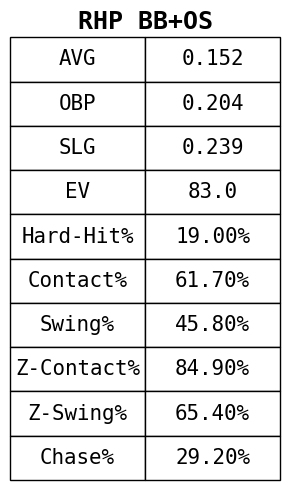

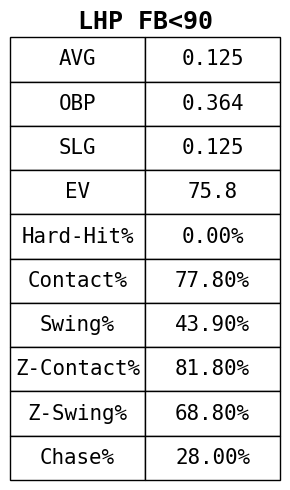

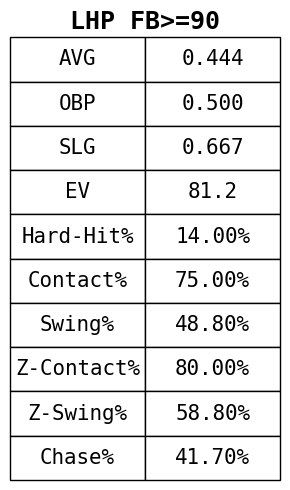

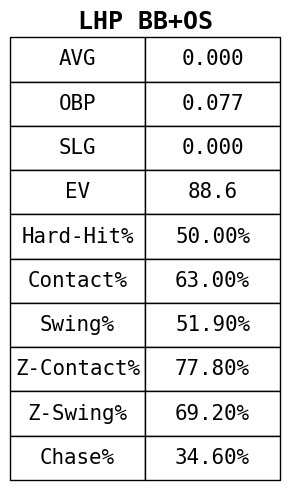

In [31]:
file_path = r"C:\Users\brend\OneDrive - Stonehill College\Copy of Falmouth - NewScout.xlsx"

MASTER_COLS = [
    "AVG", "OBP", "SLG", "EV", "Hard-Hit%", 
    "Contact%", "Swing%", "Z-Contact%", "Z-Swing%", "Chase%"
]

def normalize_name(name: str) -> str:
    return name.lower().replace(",", "").replace(" ", "")

def display_player_stats_table(ax, df, sheet_name):
    if df.empty:

        df = pd.DataFrame([[""] * len(MASTER_COLS)], columns=MASTER_COLS)
    else:

        for col in ["Contact%", "Swing%", "InZoneWhiff%", "Z-Swing%", "Chase%", "Hard-Hit%"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        if "InZoneWhiff%" in df.columns:
            df["Z-Contact%"] = (1 - df["InZoneWhiff%"]) * 100
            df["Z-Contact%"] = df["Z-Contact%"].map(lambda x: f"{x:.2f}%" if pd.notnull(x) else "")
            df.drop(columns=["InZoneWhiff%"], inplace=True)
        else:
            df["Z-Contact%"] = ""

        for col in ["Contact%", "Swing%", "Z-Swing%", "Chase%", "Hard-Hit%"]:
            if col in df.columns:
                df[col] = df[col].map(lambda x: f"{x*100:.2f}%" if pd.notnull(x) else "")

        for col in ["AVG", "OBP", "SLG"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notnull(x) else "")

        if "EV" in df.columns:
            df["EV"] = pd.to_numeric(df["EV"], errors="coerce").map(lambda x: f"{x:.1f}" if pd.notnull(x) else "")

        df = df.reindex(columns=MASTER_COLS, fill_value="")

    df_t = df.T.reset_index()
    df_t.columns = ["Stat", "Value"]

    table = ax.table(
        cellText=df_t.values,
        loc="center",
        cellLoc="center",
        colLoc="center",
        bbox=[0, 0, 1, 1]
    )
    ax.set_title(sheet_name, fontsize=18, fontweight="bold")
    ax.axis("off")
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(0.1, 0.25)

def extract_and_display(file_path, player_name_input):
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    player_filter = normalize_name(player_name_input)
    xls = pd.ExcelFile(file_path)
    sheets = xls.sheet_names

    for sheet in sheets:
        fig, ax = plt.subplots(figsize=(3, 5))
        df = pd.read_excel(xls, sheet_name=sheet)

        df["playerFullName"] = df["playerFullName"].apply(
            lambda x: f"{x.split()[-1]}, {' '.join(x.split()[:-1])}".strip() if isinstance(x, str) else ""
        )
        df["normalizedName"] = df["playerFullName"].str.lower().str.replace(",", "", regex=True).str.replace(" ", "", regex=False)

        df_filtered = df[df["normalizedName"] == player_filter]

        cols = ["AVG", "OBP", "SLG", "EV", "Hard-Hit%", "Contact%", "Swing%", "InZoneWhiff%", "Z-Swing%", "Chase%"]
        existing_cols = [col for col in cols if col in df_filtered.columns]
        df_display = df_filtered[existing_cols].copy() if not df_filtered.empty else pd.DataFrame(columns=MASTER_COLS)

        display_player_stats_table(ax, df_display, sheet)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

extract_and_display(file_path, player_name_input)

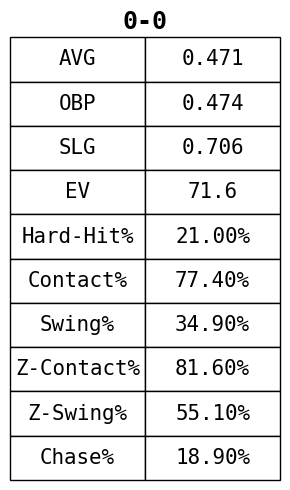

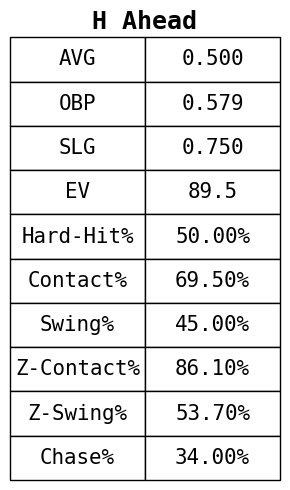

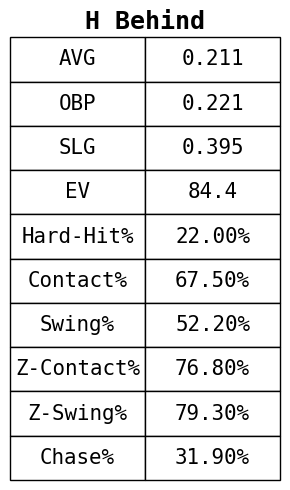

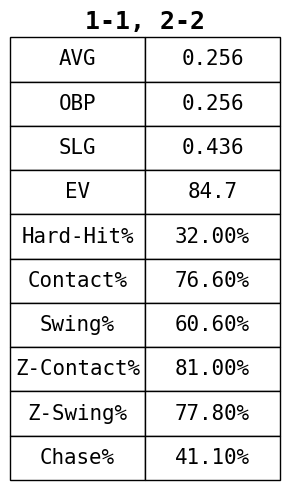

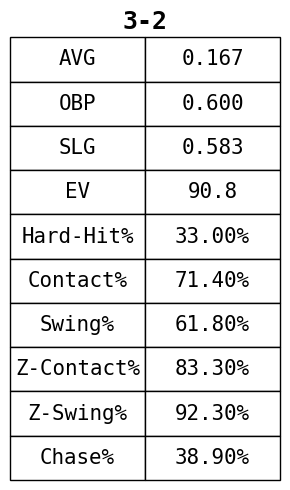

In [33]:
file_path = r"C:\Users\brend\OneDrive - Stonehill College\Falmouth Scout 3.0.xlsx"

MASTER_COLS = [
    "AVG", "OBP", "SLG", "EV", "Hard-Hit%", 
    "Contact%", "Swing%", "Z-Contact%", "Z-Swing%", "Chase%"
]

def normalize_name(name: str) -> str:
    return name.lower().replace(",", "").replace(" ", "")

def display_player_stats_table(ax, df, sheet_name):
    if df.empty:

        df = pd.DataFrame([[""] * len(MASTER_COLS)], columns=MASTER_COLS)
    else:

        for col in ["Contact%", "Swing%", "InZoneWhiff%", "Z-Swing%", "Chase%", "Hard-Hit%"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        if "InZoneWhiff%" in df.columns:
            df["Z-Contact%"] = (1 - df["InZoneWhiff%"]) * 100
            df["Z-Contact%"] = df["Z-Contact%"].map(lambda x: f"{x:.2f}%" if pd.notnull(x) else "")
            df.drop(columns=["InZoneWhiff%"], inplace=True)
        else:
            df["Z-Contact%"] = ""

        for col in ["Contact%", "Swing%", "Z-Swing%", "Chase%", "Hard-Hit%"]:
            if col in df.columns:
                df[col] = df[col].map(lambda x: f"{x*100:.2f}%" if pd.notnull(x) else "")

        for col in ["AVG", "OBP", "SLG"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notnull(x) else "")

        if "EV" in df.columns:
            df["EV"] = pd.to_numeric(df["EV"], errors="coerce").map(lambda x: f"{x:.1f}" if pd.notnull(x) else "")

        df = df.reindex(columns=MASTER_COLS, fill_value="")

    df_t = df.T.reset_index()
    df_t.columns = ["Stat", "Value"]

    table = ax.table(
        cellText=df_t.values,
        loc="center",
        cellLoc="center",
        colLoc="center",
        bbox=[0, 0, 1, 1]
    )
    ax.set_title(sheet_name, fontsize=18, fontweight="bold")
    ax.axis("off")
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(0.1, 0.25)

def extract_and_display(file_path, player_name_input):
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    player_filter = normalize_name(player_name_input)
    xls = pd.ExcelFile(file_path)
    sheets = xls.sheet_names

    for sheet in sheets:
        fig, ax = plt.subplots(figsize=(3, 5))
        df = pd.read_excel(xls, sheet_name=sheet)

        df["playerFullName"] = df["playerFullName"].apply(
            lambda x: f"{x.split()[-1]}, {' '.join(x.split()[:-1])}".strip() if isinstance(x, str) else ""
        )
        df["normalizedName"] = df["playerFullName"].str.lower().str.replace(",", "", regex=True).str.replace(" ", "", regex=False)

        df_filtered = df[df["normalizedName"] == player_filter]

        cols = ["AVG", "OBP", "SLG", "EV", "Hard-Hit%", "Contact%", "Swing%", "InZoneWhiff%", "Z-Swing%", "Chase%"]
        existing_cols = [col for col in cols if col in df_filtered.columns]
        df_display = df_filtered[existing_cols].copy() if not df_filtered.empty else pd.DataFrame(columns=MASTER_COLS)

        display_player_stats_table(ax, df_display, sheet)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

extract_and_display(file_path, player_name_input)